# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
import seaborn as sns
import os


sns.set(rc={'figure.figsize':(17,8)}) #Зададим размер фигур построеных с помощью seaborn
np.set_printoptions(threshold=np.inf)
sns.set_palette('dark')
pd.set_option('display.max_columns', None) #Уберем ограничение на максимальное число отображаемых столбцов за раз


In [3]:
pth1 = 'real_estate_data.csv'
pth2 = '/datasets/real_estate_data.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1,sep='\t')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2,sep='\t')
else:
    print('Что-то пошло не так')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Предварительно можно сделать следующие выводы по столбцам.

`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м). 
    Около 20% значений пропущено, удалять их нецелесообразно, возможно стоит взять среднее расстояние из города размещения объявления до ближайшего аэропорта.
    
`balcony` — число балконов. Учитывая число пропусков, скорее всего при заполнении объявления, вместо указания 0 в числе балконов, когда балкона нет многие просто пропускают значение, стоит дополнительно осмотреть несколько примеров для обраблотки
    
`ceiling_height` — высота потолков (м). Около 40% пропущенных значений. Скорее всего многие люди при заполнении объявления не хотят замерять потолки и просто пропускают значение. Лучше всего заполнить отстуствующие значения средним.
    
`cityCenters_nearest` — расстояние до центра города (м). По некоторым объявлениям отсутствует расстояние до центра города. Стоит заполнить их средним значением по городу.

`days_exposition` — сколько дней было размещено объявление (от публикации до снятия). Часть значений отстутвует, скорее всего объяние не было снято.

`first_day_exposition` — дата публикации. Нет пропусков, однако тип object, это означает, что дату нужно будет привести к DateTime

`floor` — этаж. Нет пропусков, тип верный.

`floors_total` — всего этажей в доме. Есть небольшое количество строк, где отстутствует число этажей. 

`is_apartment` — апартаменты (булев тип). Тип оказался не булев, а object. Скорее всего отствуеющие значение это False.

`kitchen_area` — площадь кухни в квадратных метрах (м²). В части строк нет площади кухни. Стоит узнать, не соответствует ли это квартире студии.

`last_price` — цена на момент снятия с публикации. Все строки есть.

`living_area` — жилая площадь в квадратных метрах (м²). Часть значений отстуствует, необходимо осмотреть эти строки, чтобы понять возможную причину.

`locality_name` — название населённого пункта. Тип object. Есть несколько отсутствующих значений. Так как их менее 1%, стоит удалить эти строки.

`open_plan` — свободная планировка (булев тип). Все значения есть.

`parks_around3000` — число парков в радиусе 3 км. Скорее всего там где Nan - это ноль. Требуется проверить

`parks_nearest` — расстояние до ближайшего парка (м). Скорее всего там где Nan - это ноль. Требуется проверить

`ponds_around3000` — число водоёмов в радиусе 3 км. Скорее всего там где Nan - это ноль. Требуется проверить

`ponds_nearest` — расстояние до ближайшего водоёма (м). Скорее всего там где Nan - это ноль. Требуется проверить

`rooms` — число комнат. Все значения есть.

`studio` — квартира-студия (булев тип)  Все значения есть.

`total_area` — площадь квартиры в квадратных метрах (м²). Все значения есть.

`total_images` — число фотографий квартиры в объявлении. Все значения есть.

In [4]:
df.describe() #Оценим данные

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [5]:
display(df.head(10)) #Визуальное ознакомление с данными

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Исследовав значения, мы можем придти к следующем выводам по стобцу.
1. **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м). 
    - Пропуски: Около 20% значений пропущено, удалять их нецелесообразно, возможно стоит взять среднее расстояние из города размещения объявления до ближайшего аэропорта.
    - Тип: Стоит изменить на int для удобства восприятия, так как сантиметры до аэропорта не влияют на стоимость квартиры. Или перевести в километры до первой цифры после запятой.
    - Аномалии в значениях: Отсутствуют
2. **balcony** — число балконов. 
    - Пропуски: Учитывая число пропусков, скорее всего при заполнении объявления, вместо указания 0 в числе балконов, когда балкона нет многие просто пропускают значение, стоит дополнительно осмотреть несколько примеров для обработки
    - Тип: Стоит изменить на int, так как не бывает половины балкона.
    - Аномалии в значениях: Единственное, что вызывает вопросы - 5 балконов. Стоит изучить данные строки подробнее.
3. **ceiling_height** — высота потолков (м). 
    - Пропуски:Около 40% пропущенных значений. Скорее всего многие люди при заполнении объявления не хотят замерять потолки и просто пропускают значение. Лучше всего заполнить отстуствующие значения средним.
    - Тип: Корректный
    - Аномалии: Минимум 1 метр, а Максимум 100 м. Явные ошибки, стоит изучить подробнее.
4. **cityCenters_nearest** — расстояние до центра города (м). 
    - Пропуски: По некоторым объявлениям отсутствует расстояние до центра города. Стоит заполнить их средним значением по городу.
    - Тип: Стоит заменить на int, так как сантиметры не влияют. Или перевести в километры до первой цифры после запятой.
    - Аномалии: Отсутствуют
5. **days_exposition** — сколько дней было размещено объявление (от публикации до снятия). 
    - Пропуски: Часть значений отстутвует, скорее всего объяние не было снято. Гипотеза требует проверки.
    - Тип: Стоит перевести в int, так как часы не так важны в рамках продажи квартиры.
    - Аномалии: Отсутствуют.
6. **first_day_exposition** — дата публикации. 
    - Пропуски: Нет пропусков
    - Тип: Object, это означает, что дату нужно будет привести к DateTime
    - Аномалии: Нельзя сказать пока не изменим тип.
7. **floor** — этаж. 
    - Пропуски: Нет пропусков
    - Тип: Корректный.
    - Аномалии: Отсутствуют
8. **floors_total** — всего этажей в доме. 
    - Пропуски: Есть небольшое количество строк, где отстутствует число этажей. Стоит изучить эти значений и проверить корреляцию с floor.
    - Тип: Корректный. Стоит изменить тип на int, так как не может быть половины этажа.
    - Аномалии: Вопрос вызывает 60 этажей, стоит посмотреть есть ли в данном районе такие здания.
9. **is_apartment** — апартаменты (булев тип). 
    - Пропуски: Скорее всего отствуеющие значение это False.
    - Тип: Тип оказался не булев, а object.
    - Аномалии: Нельзя проверить пока не изменим тип.
10. **kitchen_area** — площадь кухни в квадратных метрах (м²). 
    - Пропуски: В части строк нет площади кухни. Стоит узнать, не соответствует ли это квартире студии.
    - Тип: Корректный.
    - Аномалии: Отсутствуют
11. **last_price** — цена на момент снятия с публикации. Все строки есть.
    - Пропуски: Отстуствуют
    - Тип: Для удобства стоит привести к int.
    - Аномалии: Отсутствуют
12. **living_area** — жилая площадь в квадратных метрах (м²). 
    - Пропуски: Часть значений отстуствует, необходимо осмотреть эти строки, чтобы понять возможную причину.
    - Тип: Корректный.
    - Аномалии: Минимальное значение в 2 кв.м вызывает вопросы, только если не продают кладовку. В целом гипотеза о том, что в объявлениях не только квартиры, но и комнаты/помещения в доме может соотвествовать многим пропущенным значениям. У технического помещения в подвале, не может быть кухни.
13. **locality_name** — название населённого пункта. 
    - Пропуски: Есть несколько отсутствующих значений. Так как их менее 1%, стоит удалить эти строки.
    - Тип: Корректный
    - Аномалии: Неизвестно
14. **open_plan** — свободная планировка (булев тип). Все значения есть.
    - Пропуски: Отсуствуют
    - Тип: Корректный
    - Аномалии: Отсуствуют
15. **parks_around3000** — число парков в радиусе 3 км. 
    - Пропуски: Скорее всего там где Nan - это ноль. Требуется проверить
    - Тип: В строку пишется число парков, стоит изменить тип на int
    - Аномалии: Отсуствуют
16. **parks_nearest** — расстояние до ближайшего парка (м). 
    - Пропуски: Скорее всего там где Nan - это ноль. Требуется проверить
    - Тип: Стоит изменить число на int, так как сантиметрами можно принебречь.
    - Аномалии: Отсутствуют
17. **ponds_around3000** — число водоёмов в радиусе 3 км. Скорее всего там где Nan - это ноль. Требуется проверить
    - Пропуски: Скорее всего там где Nan - это ноль. Требуется проверить
    - Тип: В строку пишется число водоемов, стоит изменить тип на int
    - Аномалии: Отсуствуют
18. **ponds_nearest** — расстояние до ближайшего водоёма (м). Скорее всего там где Nan - это ноль. Требуется проверить
    - Пропуски: Скорее всего там где Nan - это ноль. Требуется проверить
    - Тип: Стоит изменить число на int, так как сантиметрами можно принебречь.
    - Аномалии: Отсутствуют
19. **rooms** — число комнат. Все значения есть.
    - Пропуски: Отсуствуют
    - Тип: Корректный
    - Аномалии: 19 комнат вызывают вопросы. Нужно посмотреть общую площадь этой квартиры.
20. **studio** — квартира-студия (булев тип)  Все значения есть.
    - Пропуски: Отсутствуют
    - Тип: Булевый
    - Аномалии: Отсутствуют
21. **total_area** — площадь квартиры в квадратных метрах (м²). Все значения есть.
    - Пропуски: Отсуствуют
    - Тип: Корректный
    - Аномалии: Нужно вывести максимум и оценить, аномалия это или нет.
22. **total_images** — число фотографий квартиры в объявлении. Все значения есть.
    - Пропуски: Отсутствуют
    - Тип: Корректный
    - Аномалии: Отсутствуют

## Предобработка данных

Построим порядок обработки значений исходя из столбцов.

**locality_name**
- Задача: Удалить отсутствющие значения. Проверить столбец на неявные дубликаты и исправить их

In [6]:
df = df.dropna(subset=['locality_name']) #Удалим отсутствующие значения
df['locality_name'].unique() #Изучим неявные дубликаты

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Для анализа неявных дубликатов было необходимо вручную ознакомиться со всеми уникальными значениями. Так как все равно каждое значение было проверено вручную, было принято решение не искать закономерности, а заменить в лоб. 

In [7]:
df = df.replace(
    {
    'Кудрово':'Деревня Кудрово',
    'Любань':'поселок Любань',
    'Мурино':'поселок Мурино',
    'посёлок Мурино':'поселок Мурино',
    'Никольское':'село Никольское',
    'городской поселок Большая Ижора':'поселок городского типа Большая Ижора',
    'городской поселок Янино-1':'городской посёлок Янино-1',
    'городской посёлок Лесогорский':'поселок городского типа Лесогорский',
    'городской посёлок Мга':'посёлок городского типа Мга',
    'городской посёлок Назия':'поселок городского типа Назия',
    'городской посёлок Павлово':'посёлок городского типа Павлово',
    'городской посёлок Рощино':'поселок городского типа Рощино',
    'посёлок городского типа Рощино':'поселок городского типа Рощино',
    'городской посёлок Советский':'поселок городского типа Советский',
    'деревня Гарболово':'поселок Гарболово',
    'деревня Зимитицы':'поселок Зимитицы',
    'деревня Калитино':'поселок Калитино',
    'деревня Щеглово':'посёлок Щеглово',
    'поселок Аннино':'посёлок Аннино',
    'поселок Бугры':'посёлок Бугры',
    'поселок Возрождение':'посёлок Возрождение',
    'поселок Гаврилово':'посёлок Гаврилово',
    'поселок Жилгородок':'посёлок Жилгородок',
    'поселок Ильичёво':'посёлок Ильичёво',
    'поселок Кобралово':'посёлок Кобралово',
    'поселок Коробицыно':'посёлок Коробицыно',
    'поселок Лисий Нос':'посёлок Лисий Нос',
    'поселок Мельниково':'посёлок Мельниково',
    'поселок Мичуринское':'посёлок Мичуринское',
    'поселок Новый Свет':'посёлок Новый Свет',
    'поселок Пансионат Зелёный Бор':'посёлок Пансионат Зелёный Бор',
    'поселок Перово':'посёлок Перово',
    'поселок Петровское':'посёлок Петровское',
    'поселок Победа':'посёлок Победа',
    'поселок Поляны':'посёлок Поляны',
    'поселок Рябово':'поселок городского типа Рябово',
    'посёлок городского типа Рябово':'поселок городского типа Рябово', 
    'поселок Старая Малукса':'посёлок Старая Малукса',
    'поселок Стеклянный':'посёлок Стеклянный',
    'поселок Сумино':'посёлок Сумино',
    'поселок Тельмана':'посёлок Тельмана',
    'поселок Терволово':'посёлок Терволово',
    'поселок Усть-Луга':'посёлок Усть-Луга',
    'поселок городского типа Вырица':'посёлок городского типа Вырица',
    'поселок городского типа Красный Бор':'посёлок городского типа Красный Бор',
    'поселок городского типа Кузьмоловский':'посёлок городского типа Кузьмоловский',
    'поселок городского типа Лебяжье':'посёлок городского типа Лебяжье',
    'поселок городского типа Токсово':'посёлок городского типа Токсово',
    'поселок городского типа Форносово':'посёлок городского типа Форносово',
    'поселок станции Вещево':'посёлок при железнодорожной станции Вещево',
    'поселок станции Приветнинское':'посёлок при железнодорожной станции Приветнинское'
    }
)

**airports_nearest**
- Задача: Найти среднее по городу размещение и заменить отсутствющие значения на данное значение.

In [8]:
airport_table = df['airports_nearest'].groupby(df['locality_name']).mean().dropna() #Создадим таблицу, где указано среднее для всех всех городов где есть хотя бы одно значение

def replacement(city,air_bool,default): #Функция заменяет отсуствующие значения на среднее по городу, если среднего нет, то на 0
    if city in airport_table.index:
        if air_bool == True:
            dest_new = airport_table.loc[airport_table.index == city][city]
            return dest_new
        else:
            return default
    else:
        dest_new = 0
        return dest_new
df['airports_bool'] = df['airports_nearest'].isnull() #Создадим временный столбец для удобной работы функции
df['airports_nearest'] = df.apply(lambda x : replacement(x.locality_name, x.airports_bool, x.airports_nearest), axis=1) #Применим ф-цию 
display(df.loc[df['airports_nearest'].isnull()].head()) #Проверим правильность работы функции
df.drop('airports_bool',axis=1, inplace=True) #Удалим временный столбец

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,airports_bool


Идея со средним по городу может иметь смысл только там, где есть информация о расстоянии до аэропорта. При выгрузке данных не везде получилось определить расстояние до ближайшего аэропорта и значения приняли `NaN` по всему городу.

Решением стало - заменить все отсутствующие значения в таких городах на `0`. Если нам понадобится проанализировать столбец, нужно будет отсечь нулевые значения, для получения корректных значений.

**balcony** — число балконов. 
    
- Задача: Изменить тип на int, вывести на экран пропуски и изучить их. Заменить пропуски. Изучить квартиры с `5` балконами

In [9]:
display(df.loc[df['balcony'].isna()].head(15)) #Изучим пропуски

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,0.0,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,поселок Мурино,51553.0,NaN,NaN,NaN,NaN,NaN,189.0
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,NaN,False,False,8.50,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0
16,11,6700000.0,82.00,2017-11-23T00:00:00,3,3.05,5.0,55.60,1,NaN,False,False,9.00,NaN,Санкт-Петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0
19,16,14200000.0,121.00,2019-01-09T00:00:00,3,2.75,16.0,76.00,8,NaN,False,False,12.00,NaN,Санкт-Петербург,38900.0,12843.0,0.0,NaN,0.0,NaN,97.0
23,11,2950000.0,32.00,2016-10-29T00:00:00,1,2.60,9.0,17.70,9,NaN,False,False,6.10,NaN,Санкт-Петербург,15414.0,14211.0,2.0,517.0,1.0,190.0,615.0
26,6,4050000.0,60.00,2017-04-28T00:00:00,4,NaN,5.0,43.00,4,NaN,False,False,7.00,NaN,Санкт-Петербург,11580.0,10510.0,0.0,NaN,1.0,95.0,265.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,0.0,NaN,NaN,NaN,NaN,NaN,63.0


Мы не видим связи между неуказанным числом балконов и этажом. У большей части квартир есть балкон или лоджия. Однако встает вопрос, можем ли мы назвать лоджию балконом? Если да, то пустые значения нужно заполнить единицами, если нет, то нулями. 
Большая часть современных домов, обладает лоджией, а не балконом. Принимаем, что `Лоджия != Балкону`. 

In [10]:
df['balcony'] = df['balcony'].fillna(0) #Заполним пропуски на 0

**ceiling_height** — высота потолков (м). 

- Задача: Изучить потолки меньше `2-х` метров и больше `4` метров, принять решение об обработке. Заполнить `Nan` на среднее по таблице

СНиП регулирует высоту потолков в квартирах. Минимальное значение `2.1 м`. Примем `2 м`, как некоторое допустимое нарушение вызванное натяжным потолком.
Возникается вопрос, что считать высокими потолками. Мы не будем брать уникальные проекты (вроде пентхаусов), аналитика о больших числах. Высокими потолками в рамках элитного жилья считаются `4 м`. Примем это как некоторый максимум, выше которого значения будем считать выбросами.

In [11]:
display(df.loc[(df['ceiling_height'] < 2) | (df['ceiling_height'] > 4)]) #Выведем значения которые мы считаем выбросами

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.0,2018-11-06T00:00:00,3,4.15,3.0,44.2,2,NaN,False,False,12.2,0.0,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.00,5.0,32.0,2,False,False,False,NaN,2.0,Гатчина,0.0,NaN,NaN,NaN,NaN,NaN,259.0
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,NaN,False,False,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.0,3,NaN,False,False,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.00,3.0,NaN,1,False,False,False,NaN,0.0,Бокситогорск,0.0,NaN,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.00,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
22494,7,91075000.0,491.0,2017-05-27T00:00:00,5,4.20,9.0,274.0,9,NaN,False,False,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,False,False,10.0,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.00,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Мы видим, что таких значений `78`. Из за них небольшого количества мы запишем вместо этих значений медианное.
А вместо пропусков среднее после замены выбросов на медиану.

In [16]:
ceil_median = df['ceiling_height'].median() #Вычислим медиану
df['ceiling_height'].loc[(df['ceiling_height'] < 2) | (df['ceiling_height'] > 4)] = ceil_median #Заменим выбросы на медиану
ceil_mean = df['ceiling_height'].mean() #Вычислим среднее
df['ceiling_height'] = df['ceiling_height'].fillna(ceil_mean) #Заменим пропуски на среднее
print('Число пропущенных значений:',df['ceiling_height'].isna().sum()) #Проверим успешность замены

Число пропущенных значений: 0


**cityCenters_nearest** — расстояние до центра города (м). 

- Задача: Изменить тип. Посчитать среднее значение по городу и заменить отсутствующие значеняе на среднее значение по городу.

In [17]:
city_table = df['cityCenters_nearest'].groupby(df['locality_name']).mean().dropna()#Создадим таблицу, где указано среднее для всех всех городов где есть хотя бы одно значение
def replacement_city(city,city_bool,default): #Функция заменяет отсуствующие значения на среднее по городу, если среднего нет, то на 0
    if city in city_table.index:
        if city_bool == True:
            dest_new = city_table.loc[city_table.index == city][city]
            return dest_new
        else:
            return default
    else:
        dest_new = 0
        return dest_new
df['city_bool'] = df['cityCenters_nearest'].isnull()  #Создадим временный столбец для удобной работы функции
df['cityCenters_nearest'] = df.apply(lambda x : replacement(x.locality_name, x.city_bool, x.cityCenters_nearest),axis=1)#Применим функцию
df.drop('city_bool',axis=1, inplace=True) #Удалим временный стобец

**first_day_exposition** — дата публикации. 

- Задача: Привести тип к DateTime, исследовать на предмет аномалий

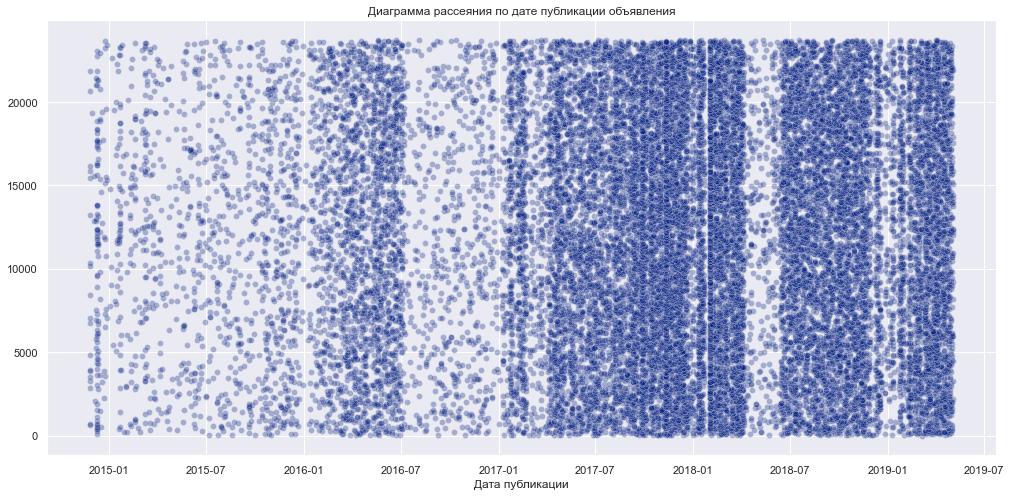

In [18]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y%m%dT%H:%M:%S') #Приведем тип к DateTime

sns.scatterplot(data=df,x='first_day_exposition',y=df.index, alpha=0.3)
plt.xlabel('Дата публикации')
plt.title('Диаграмма рассеяния по дате публикации объявления')
plt.show()

Аномалий не обнаружено, как и пустых значений.

**days_exposition** — сколько дней было размещено объявление (от публикации до снятия). 
    
- Задача: Ознакомиться со строками с отсутствующими значениями. Принять решение об их обработке. Перевести тип в int

In [19]:
display(df.loc[df['days_exposition'].isna()]) #Ознакомимся с отсуствующими значениями

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16.0,51.0,8,NaN,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18,2,2.720359,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18,1,2.720359,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02,2,2.650000,9.0,30.3,7,NaN,False,False,7.00,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31,2,2.600000,24.0,29.7,9,NaN,False,False,8.30,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02,4,3.000000,26.0,71.4,17,NaN,False,False,15.60,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24,1,2.500000,5.0,17.3,5,NaN,False,False,5.60,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21,3,3.700000,5.0,73.3,3,NaN,False,False,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.720359,3.0,29.7,1,NaN,False,False,NaN,0.0,село Рождествено,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Скорее всего, причиной `NaN` в `days_exposition`, учитывая, что данный столбец был выгружен программой, является то, что на момент выгрузки данные объявления не были закрыты. Нет ничего странного, что некоторые объявления могут висеть несколько лет.

Это может быть вызванно особенностями собственника, переоценкой квартиры или серьезными недостатками.

Исходя из этого мы заменим все `NaN` на маркер `9999` и при анализе сможем откинуть данные значения, при изучении времени продажи квартиры


In [20]:
df['days_exposition'] = df['days_exposition'].fillna(9999) #Заменим пропуски на маркер
print('Число пропущенных значений:',df['days_exposition'].isna().sum()) 

Число пропущенных значений: 0


**floors_total** — всего этажей в доме. 
- Задача: Изучить строки с более чем `37` этажами (Высота ЖК "Князь Александр Невский", выше только два бизнес центра). Принять решение об аномалиях. Заполнить пропуски. Изменить тип на `int`.

In [21]:
display(df.loc[df['floors_total'] >= 37].head()) #Проверим число квартир на 37 и более этажах

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,NaN,False,False,7.40,0.0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52.0,10.5,18,NaN,False,False,14.00,0.0,Санкт-Петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0
16934,5,4100000.0,40.0,2017-10-17,1,2.65,37.0,17.4,5,NaN,False,False,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0


Как мы видим, это не аномалии, таких квартир было всего `3`. Здание в `60` этажей странно, что находится на Кронштадте, таких зданий там нет, но неподалеку Лахта Центр, где как раз столько этажей. Будем считать это не ошибкой. 
Пропуски заполним средними значениями, их немного и они не повлияют на анализ цены на первом и последнем этаже. 

In [22]:
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].mean()) #Заменим все пропуски на среднее
print('Число пропущенных значений:',df['floors_total'].isna().sum())

Число пропущенных значений: 0


**is_apartment** — апартаменты (булев тип). 
- Задача: Отсутствующие значения заменить на False.

В предыдущих пунктах мы заметили, что в столбце `is_apartment` есть значения `False`, `NaN`, `True`. Нужно понять какие вообще значения там есть.

In [23]:
print(df['is_apartment'].unique()) #Выведем уникальные значения стобца

[nan False True]


Как мы видим, `is_apartment` как мы и думали принимает только три значения. Апартаменты встречаются реже чем квартиры, по этому мы предполагаем, что `NaN` это `False`.

In [24]:
df['is_apartment'] = df['is_apartment'].fillna(False) #Заполним пропуски
print('Число пропущенных значений:',df['is_apartment'].isna().sum())

Число пропущенных значений: 0


**kitchen_area** — площадь кухни в квадратных метрах (м²). 
- Задача: Проверить пропуски, принять решение о замене.

In [25]:
display(df.loc[df['kitchen_area'].isna()]) #Изучим пропуски

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24,3,2.720359,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19,1,2.720359,9.0,NaN,2,False,False,False,NaN,0.0,Коммунар,0.0,0.0,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28,2,2.500000,5.0,NaN,1,False,False,False,NaN,0.0,посёлок городского типа Красный Бор,0.0,0.0,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18,1,2.720359,22.0,NaN,3,False,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,9999.0
59,15,6300000.0,46.5,2017-03-06,1,2.720359,13.0,NaN,13,False,False,False,NaN,0.0,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08,1,2.560000,18.0,19.6,10,False,False,False,NaN,0.0,село Никольское,0.0,0.0,NaN,NaN,NaN,NaN,627.0
23663,12,6400000.0,88.0,2018-01-12,4,2.550000,10.0,NaN,1,False,False,False,NaN,0.0,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.6,2018-02-08,1,2.800000,9.0,NaN,2,False,False,False,NaN,0.0,поселок городского типа Синявино,0.0,0.0,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08,1,2.720359,9.0,NaN,4,False,False,False,NaN,0.0,Сосновый Бор,0.0,0.0,NaN,NaN,NaN,NaN,45.0


Как мы видим нет связи между пропусками в площади кухни и например тем, является ли квартира студией. 

Но есть много совпадающих пропусков, где не указано и жилая площадь. Скорее всего это связано с тем, что не все, кто выставляют объявления хотят замерять площадь кухни. Таких значений чуть меньше чем 10%. 

Для точности мы вычислим среднее отношение площади кухни к общей площади и применим его на отсутствующие значения. Так же поступим и с жилой площадью в дальнейшем

In [26]:
kitchen_prop = (df['kitchen_area'] / df['total_area']).mean() #Вычислим среднее отношение размера кухни к общей площади
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * kitchen_prop) #Заменим пропуски на общую площадь умноженную на среднее соотношение
print('Число пропущенных значений:',df['kitchen_area'].isna().sum())

Число пропущенных значений: 0


**last_price** — цена на момент снятия с публикации. Все строки есть.
- Задача: Изменить тип на int

In [27]:
df['last_price'] = df['last_price'].astype('int64') #Изменим тип

**living_area** — жилая площадь в квадратных метрах (м²). 
- Задача: Изучить строки с пропущенными значениями, изучить строки с аномально низким значением. Принять решение о замене.

In [28]:
living_prop = (df['living_area'] / df['total_area']).mean() #Вычислим среднее отношение размера жилой площади к общей площади
df['living_area'] = df['living_area'].fillna(df['total_area'] * living_prop)  #Заменим пропуски на общую площадь умноженную на среднее соотношение
print('Число пропущенных значений:',df['living_area'].isna().sum())

Число пропущенных значений: 0


**parks_around3000** — число парков в радиусе 3 км. 
- Задача: Проверить отсуствующие значения, принять решение о замене. Изменить тип на `int`

In [29]:
display(df.loc[df['parks_around3000'].isnull()].head(20)) #Изучим пропуски

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000,30.40,2018-09-10,1,2.720359,12.0,14.40000,5,False,False,False,9.100000,0.0,городской посёлок Янино-1,0.000000,0.000000,NaN,NaN,NaN,NaN,55.0
8,20,2900000,33.16,2018-05-23,1,2.720359,27.0,15.43000,26,False,False,False,8.810000,0.0,поселок Мурино,51553.000000,51553.000000,NaN,NaN,NaN,NaN,189.0
12,10,3890000,54.00,2016-06-30,2,2.720359,5.0,30.00000,5,False,False,False,9.000000,0.0,Сертолово,0.000000,0.000000,NaN,NaN,NaN,NaN,90.0
22,20,5000000,58.00,2017-04-24,2,2.750000,25.0,30.00000,15,False,False,False,11.000000,2.0,деревня Кудрово,0.000000,0.000000,NaN,NaN,NaN,NaN,60.0
30,12,2200000,32.80,2018-02-19,1,2.720359,9.0,18.52380,2,False,False,False,6.145786,0.0,Коммунар,0.000000,0.000000,NaN,NaN,NaN,NaN,63.0
37,10,1990000,45.80,2017-10-28,2,2.500000,5.0,25.86555,1,False,False,False,8.581616,0.0,посёлок городского типа Красный Бор,0.000000,0.000000,NaN,NaN,NaN,NaN,196.0
38,10,3150000,40.00,2018-03-29,1,2.750000,18.0,16.30000,9,False,False,False,11.600000,0.0,поселок Мурино,51553.000000,51553.000000,NaN,NaN,NaN,NaN,103.0
47,17,3600000,56.10,2018-10-18,3,2.720359,4.0,42.50000,3,False,False,False,5.700000,1.0,Гатчина,0.000000,0.000000,NaN,NaN,NaN,NaN,179.0
60,3,2740000,35.00,2018-01-01,1,2.720359,12.0,19.76625,8,False,False,False,6.558003,0.0,поселок Мурино,51553.000000,51553.000000,NaN,NaN,NaN,NaN,11.0
62,0,4800000,78.60,2017-09-17,3,2.800000,9.0,48.80000,5,False,False,False,11.900000,2.0,Сертолово,0.000000,0.000000,NaN,NaN,NaN,NaN,5.0


Исходя из минимального значения, и корреляции с столбом ближайшие парки, мы можем сделать вывод, что `NaN` скрывает в себе `0`.

In [30]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)  #Заменим пропуски на 0
print('Число пропущенных значений:',df['parks_around3000'].isna().sum())

Число пропущенных значений: 0


**parks_nearest** — расстояние до ближайшего парка (м). 
- Задача: Проверить отстуствующие значения, принять решение о замене. Изменить тип на `int`

Исходя из минимального значения, и корреляции парками в радиусе `3 км`, мы можем сделать вывод, что `NaN` скрывает в себе `0.` 
Такой же вывод мы можем сделать по отношению к прудам

In [31]:
df['parks_nearest'] = df['parks_nearest'].fillna(0) #Заменим пропуски на 0
print('Число пропущенных значений:',df['parks_nearest'].isna().sum())

Число пропущенных значений: 0


**ponds_around3000** — число водоёмов в радиусе 3 км. Скорее всего там где Nan - это ноль. Требуется проверить
- Задача: Проверить отсуствующие значения, принять решение о замене. Изменить тип на int

In [32]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0) #Заменим пропуски на 0
print('Число пропущенных значений:',df['ponds_around3000'].isna().sum())

Число пропущенных значений: 0


**ponds_nearest** — расстояние до ближайшего водоёма (м). Скорее всего там где Nan - это ноль. Требуется проверить
- Задача: Проверить отстуствующие значения, принять решение о замене. Изменить тип на int

In [33]:
df['ponds_nearest'] = df['ponds_nearest'].fillna(0) #Заменим пропуски на 0
print('Число пропущенных значений:',df['ponds_nearest'].isna().sum())

Число пропущенных значений: 0


**rooms** — число комнат. Все значения есть.
- Задача: Изучить аномально большое число комнат, принять решение о замене

In [34]:
display(df.loc[df['rooms'] >= 8]) #Изучим квартиры с числом комнат 8 и более

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000,183.7,2018-07-01,11,3.400000,7.0,138.80000,7,False,False,False,13.300000,0.0,Санкт-Петербург,23606.0,3148.0,0.0,0.0,0.0,0.0,9999.0
813,7,16500000,229.0,2016-02-25,8,2.720359,6.0,160.00000,5,False,False,False,25.000000,0.0,Санкт-Петербург,23968.0,4536.0,1.0,243.0,0.0,0.0,806.0
866,5,25000000,363.0,2017-12-23,14,3.160000,5.0,222.00000,4,False,False,False,16.600000,0.0,Санкт-Петербург,38076.0,7950.0,0.0,0.0,2.0,435.0,418.0
4149,6,23000000,272.6,2018-01-11,10,3.140000,7.0,145.90000,7,False,False,False,18.800000,1.0,Санкт-Петербург,10726.0,12169.0,1.0,191.0,1.0,531.0,9999.0
4435,13,22190000,191.2,2017-12-05,8,2.900000,6.0,115.80000,1,False,False,False,5.000000,0.0,Санкт-Петербург,21589.0,1152.0,1.0,587.0,2.0,155.0,115.0
5358,20,65000000,590.0,2019-02-14,15,3.500000,6.0,409.00000,3,False,False,False,100.000000,0.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,0.0,14.0
7857,11,150000000,230.0,2017-10-25,8,2.720359,8.0,220.00000,8,False,False,False,43.095451,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,0.0,135.0
8758,5,16100000,150.0,2018-07-10,8,2.920000,5.0,107.00000,1,False,False,False,7.200000,0.0,Санкт-Петербург,26080.0,4782.0,2.0,473.0,0.0,0.0,9999.0
8822,14,49968900,398.0,2017-07-12,9,3.000000,2.0,160.10000,1,False,False,False,41.000000,0.0,Санкт-Петербург,17720.0,16722.0,3.0,471.0,2.0,440.0,471.0
8860,12,17000000,235.0,2018-07-14,9,3.000000,6.0,132.71625,3,False,False,False,44.032309,0.0,Санкт-Петербург,24466.0,5034.0,1.0,346.0,0.0,0.0,90.0


Как мы видим во всех случаях у квартиры достаточно большая площадь и хотя площадь комнаты может нарушать СНиПы, мы можем говорить, что аномальное число комнат не является ошибкой, а может быть планировкой коммунальной квартиры или под коммунальную квартиру.

**total_area** — площадь квартиры в квадратных метрах (м²). Все значения есть.
- Задача: Изучить максимум, принять решение о замене

In [35]:
display(df.loc[df['total_area'] >= 500]) #Изучим аномально большие значения

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3117,19,140000000,631.0,2019-03-30,7,2.720359,5.0,356.357249,5,False,False,False,60.000000,0.0,Санкт-Петербург,25707.000000,4972.0,0.0,0.0,2.0,210.0,9999.0
4237,1,50000000,517.0,2017-10-14,7,2.720359,4.0,332.000000,3,False,False,False,22.000000,0.0,Санкт-Петербург,22835.000000,1847.0,2.0,477.0,2.0,540.0,9999.0
5358,20,65000000,590.0,2019-02-14,15,3.500000,6.0,409.000000,3,False,False,False,100.000000,0.0,Санкт-Петербург,24447.000000,4666.0,1.0,767.0,0.0,0.0,14.0
5893,3,230000000,500.0,2017-05-31,6,2.720359,7.0,282.374999,7,False,False,False,40.000000,0.0,Санкт-Петербург,32440.000000,5297.0,0.0,0.0,2.0,198.0,50.0
8018,20,84000000,507.0,2015-12-17,5,2.650000,7.0,301.500000,7,True,False,False,45.500000,1.0,Санкт-Петербург,28046.186237,5735.0,2.0,110.0,0.0,0.0,1078.0
12859,20,140000000,631.2,2019-04-09,7,3.900000,4.0,322.300000,4,False,False,False,19.500000,1.0,Санкт-Петербург,25707.000000,4972.0,0.0,0.0,2.0,210.0,9999.0
15016,8,150000000,500.0,2016-01-13,4,3.200000,7.0,282.374999,7,False,False,False,93.685764,0.0,Санкт-Петербург,33058.000000,6150.0,3.0,209.0,3.0,531.0,303.0
15651,20,300000000,618.0,2017-12-18,7,3.400000,7.0,258.000000,5,False,False,False,70.000000,0.0,Санкт-Петербург,32440.000000,5297.0,0.0,0.0,2.0,198.0,111.0
19540,8,420000000,900.0,2017-12-06,12,2.800000,25.0,409.700000,25,False,False,False,112.000000,0.0,Санкт-Петербург,30706.000000,7877.0,0.0,0.0,2.0,318.0,106.0


Исходя из таблицы, мы можем сказать, что большая площадь не является ошибкой и соотносится с числом комнат и ценой квартиры.

**Удаление явных дубликатов**

In [36]:
a = len(df)
df = df.drop_duplicates().reset_index(drop=True) #Удалим все дубликаты строк и обновим индексацию
print('Количество удаленных значений:', a - len(df)) #Выведем длину датафрейма после удаления
print('Доля удаленных значений:{:.2%}'.format(1 - len(df)/a)) #Выведем длину датафрейма после удаления

Количество удаленных значений: 0
Доля удаленных значений:0.00%


Явные дубликаты отсутствуют

**Приведение типов данных**

In [37]:
df['ponds_nearest'] = df['ponds_nearest'].astype('int64') 
df['ponds_around3000'] = df['ponds_around3000'].astype('int64') 
df['parks_nearest'] = df['parks_nearest'].astype('int64')
df['parks_around3000'] = df['parks_around3000'].astype('int64') 
df['floors_total'] = df['floors_total'].astype('int64') 
df['days_exposition'] = df['days_exposition'].astype('int64') 
df['balcony'] = df['balcony'].astype('int64') 
df['airports_nearest'] = df['airports_nearest'].astype('int64') 

### Вывод 

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

1. Отсуствующие значения удалены или заменены.
2. Неявные дубликаты заменены
3. Для дальнейшего анализа требуется учитывать следующие факторы:
    - Отсутсвующие значения в `days_exposition` приняты как маркер в `9999`, при анализе данного столбца их нужно будет убрать
    - Отсутсвующие значения в `cityCenters_nearest` и `airports_nearest` для городов где данный столбец пустой, заменены на `0`. При анализе данных столбцов, нужно отфильтровать все `0`.


## Расчёты и добавление результатов в таблицу

- **Задача:** Необходимо добавить в таблицу цену квадратного метра, день, месяц, год публикации объявления, категорию квартиры (в зависимости от этажа), соотношение общей площади к кухне и соотношение общей площади к жилой


In [39]:
df['m2_price'] = df['last_price'] / df['total_area'] #Добавим стоимость квадратного метра
df['m2_price'] = df['m2_price'].astype('int64') #Изменим тип данных
df['kitchen_prop'] = df['kitchen_area'] / df['total_area'] #Добавим соотношение кухни к общей площади
df['living_prop'] = df['living_area'] / df['total_area'] # Добавим соотношение жилой площади к общей
df['weekday_ad'] = df['first_day_exposition'].dt.day_name() #Добавим день недели публикации объявления 
df['month_ad'] = df['first_day_exposition'].dt.month_name() #Добавим название месяца публикации объявления
df['year_ad'] = df['first_day_exposition'].dt.year #Добавим год публикации объявления

def cat_fl(floor, floors_total): #Создадим ф-цию которая присвоит категорию для квартиры. На первом этаже, на последнем и другое
    if floor == 1:
        cat = 'first_floor'
        return cat
    elif floor >= floors_total:
        cat = 'last_floor'
        return cat
    else:
        cat = 'diffirent'
        return cat
df['flat_cat'] = df.apply(lambda x: cat_fl(x.floor, x.floors_total), axis=1) #Применим функцию
display(df.head(30)) #Проверим результат выполнения

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,kitchen_prop,living_prop,weekday_ad,month_ad,year_ad,flat_cat
0,20,13000000,108.00,2019-03-07,3,2.700000,16,51.00000,8,False,False,False,25.000000,0,Санкт-Петербург,18863,16028.0,1,482,2,755,9999,120370,0.231481,0.472222,Thursday,March,2019,diffirent
1,7,3350000,40.40,2018-12-04,1,2.720359,11,18.60000,1,False,False,False,11.000000,2,посёлок Шушары,12817,18603.0,0,0,0,0,81,82920,0.272277,0.460396,Tuesday,December,2018,first_floor
2,10,5196000,56.00,2015-08-20,2,2.720359,5,34.30000,4,False,False,False,8.300000,0,Санкт-Петербург,21741,13933.0,1,90,2,574,558,92785,0.148214,0.612500,Thursday,August,2015,diffirent
3,0,64900000,159.00,2015-07-24,3,2.720359,14,89.79525,9,False,False,False,29.792073,0,Санкт-Петербург,28098,6800.0,2,84,3,234,424,408176,0.187372,0.564750,Friday,July,2015,diffirent
4,2,10000000,100.00,2018-06-19,2,3.030000,14,32.00000,13,False,False,False,41.000000,0,Санкт-Петербург,31856,8098.0,2,112,1,48,121,100000,0.410000,0.320000,Tuesday,June,2018,diffirent
5,10,2890000,30.40,2018-09-10,1,2.720359,12,14.40000,5,False,False,False,9.100000,0,городской посёлок Янино-1,0,0.0,0,0,0,0,55,95065,0.299342,0.473684,Monday,September,2018,diffirent
6,6,3700000,37.30,2017-11-02,1,2.720359,26,10.60000,6,False,False,False,14.400000,1,посёлок Парголово,52996,19143.0,0,0,0,0,155,99195,0.386059,0.284182,Thursday,November,2017,diffirent
7,5,7915000,71.60,2019-04-18,2,2.720359,24,40.43610,22,False,False,False,18.900000,2,Санкт-Петербург,23982,11634.0,0,0,0,0,9999,110544,0.263966,0.564750,Thursday,April,2019,diffirent
8,20,2900000,33.16,2018-05-23,1,2.720359,27,15.43000,26,False,False,False,8.810000,0,поселок Мурино,51553,51553.0,0,0,0,0,189,87454,0.265682,0.465320,Wednesday,May,2018,diffirent
9,18,5400000,61.00,2017-02-26,3,2.500000,9,43.60000,7,False,False,False,6.500000,2,Санкт-Петербург,50898,15008.0,0,0,0,0,289,88524,0.106557,0.714754,Sunday,February,2017,diffirent


Исследуем гистограммы, параметров, которые мы ввели для оценки распределения

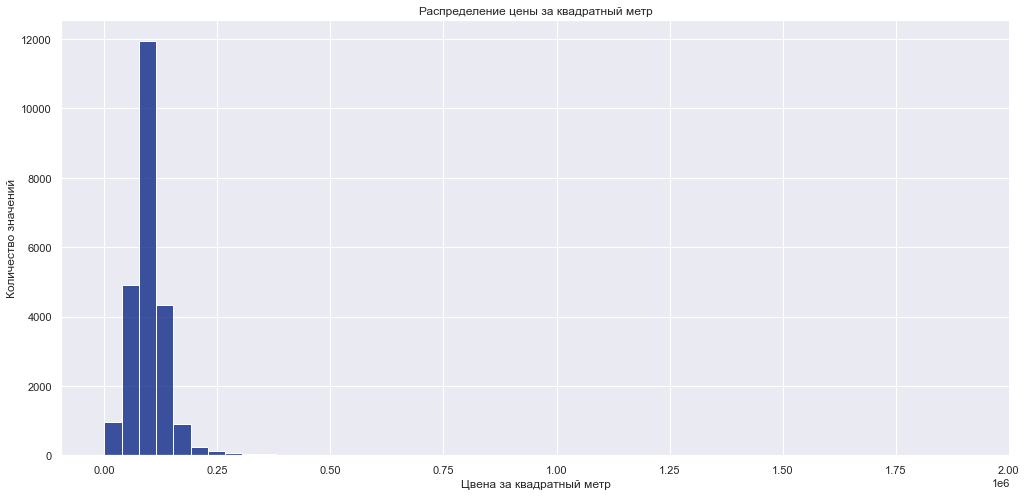

In [64]:
sns.histplot(data=df,x='m2_price',bins=50) #Построим гистограмму
plt.ylabel('Количество значений')
plt.xlabel('Цена за квадратный метр')
plt.title('Распределение цены за квадратный метр')
plt.show()

Цена за квадратный метр имеет нормальное распределение

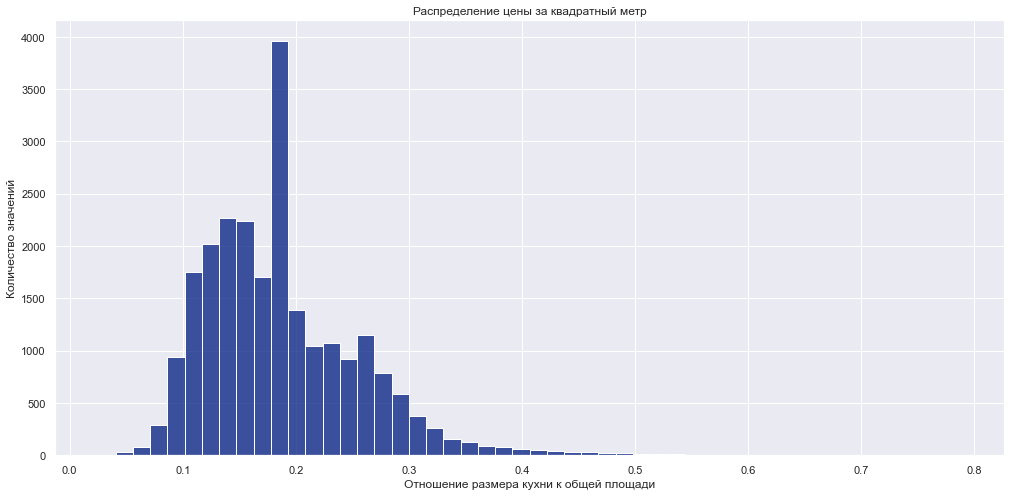

In [66]:
sns.histplot(data=df,x='kitchen_prop',bins=50) #Построим гистограмму
plt.ylabel('Количество значений')
plt.xlabel('Отношение размера кухни к общей площади')
plt.title('Распределение цены за квадратный метр')
plt.show()

Соотношение размера кухни к общей площади имеет нормальное распределение. Явно выделяется результат замен

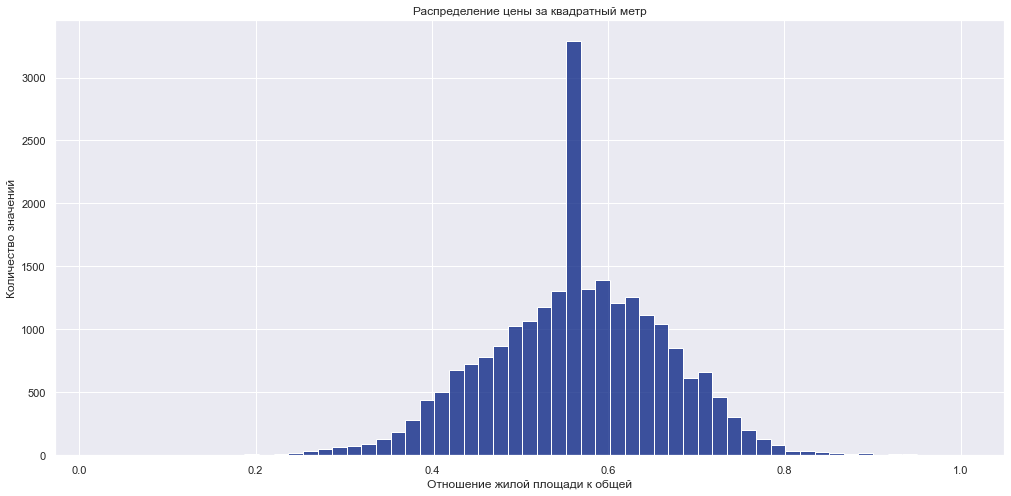

In [67]:
sns.histplot(data=df,x='living_prop',bins=59) #Построим гистограмму
plt.ylabel('Количество значений')
plt.xlabel('Отношение жилой площади к общей')
plt.title('Распределение цены за квадратный метр')
plt.show()

Соотношение размера жилой площади к общей площади имеет нормальное распределение. Явно выделяется результат замен.

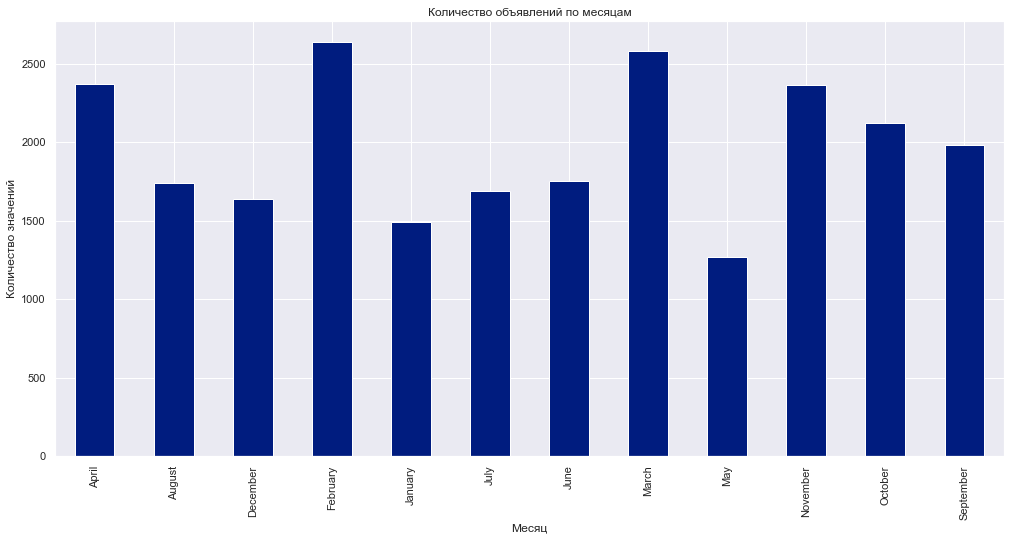

In [76]:
df.groupby(by='month_ad').agg('living_prop').count().plot.bar() #Построим столбчатый график
plt.ylabel('Количество значений')
plt.xlabel('Месяц')
plt.title('Количество объявлений по месяцам')
plt.show()

Больше всего объявлений размещается в Марте и Феврале. Меньше всего в Мае и Январе.

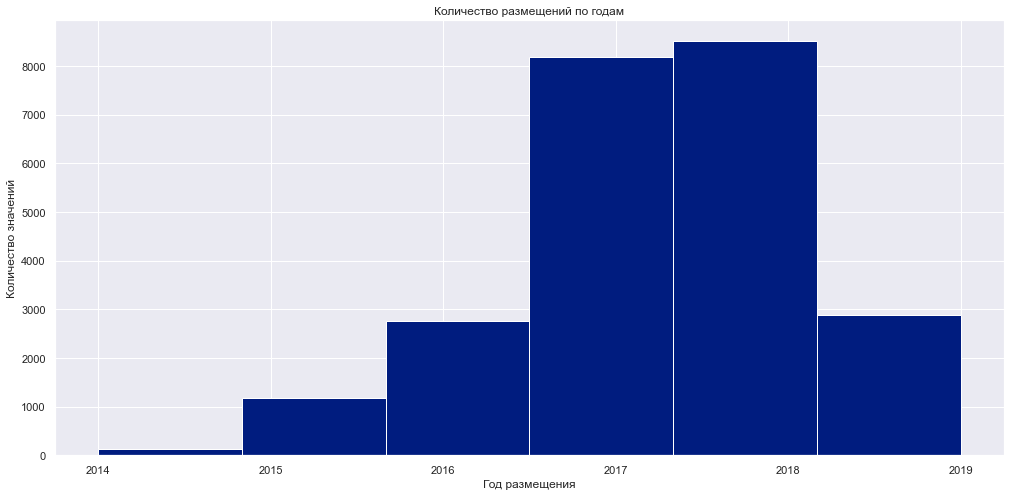

In [73]:
df['year_ad'].plot(x='year_ad',kind='hist',bins=6) #Построим столбчатый график
plt.ylabel('Количество значений')
plt.xlabel('Год размещения')
plt.title('Количество размещений по годам')
plt.show()

По годам больше всего размещений было в 2017 и 2018 годах, а в 2019 произошел резкий спад. Скорее всего это связано с тем, что выгрузка заканчивается в начале мая 2019 из за чего большая часть объявлений не попала в выгрузку. Если нам нужно будет проводить анализ по самым удачным годам, стоит исключить 2019 из выборки.

### Вывод 

**Изучив гистограммы мы можем сделать следующий вывод.**
1. Так как пропущенных значений в жилой площади и площади кухни было много, их заполнение повлияло на гистограммы. В целом можно говорить, что в связи с большим количеством пропусков эти значения плохо подходят для дальнейшего анализа. Если нам когда либо нужно будет исследовать влияение площади кухни и жилой площади на цену, нужно будет просто убрать данные значения из таблицы.
2. Цена за квадратные метры распределена нормально и мы можем видеть ярко выраженную рыночную цену.
3. С точки зрения дней продаж, мы можем увидеть, что частота размещения не зависит от дня, кроме выходных, скорее всего это связано с тем, что агенства недвижимости не размещают объявления в выходные дни.
4. Больше всего размещений в феврале,марте, апреле традиционно одними из самых насыщенных месяцев, а меньше всего в мае, что связано с длинным праздниками.
5. По годам больше всего размещений было в `2017` и `2018` годах, а в `2019` произошел резкий спад. Скорее всего это связано с тем, что выгрузка заканчивается в начале мая `2019` из за чего большая часть объявлений не попала в выгрузку. Если нам нужно будет проводить анализ по самым удачным годам, стоит исключить `2019` из выборки.

## Исследовательский анализ данных

### **Задача:** Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?»

Для начала напомним, что там где в `days_exposition` был `NaN` стоит маркер `9999`. Нам нужно помнить это и избавиться от маркера через срез данных.

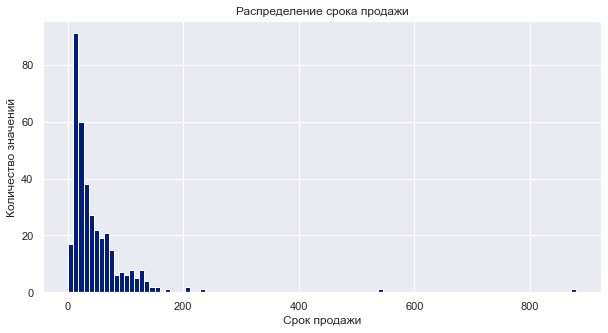

In [79]:
(
    df.query('days_exposition < 365').groupby(by='days_exposition').agg('flat_cat').count()
    .plot(kind='hist',bins=100,figsize=(10,5))
) #Построим гистограмму
plt.ylabel('Количество значений')
plt.xlabel('Срок продажи')
plt.title('Распределение срока продажи')
plt.show()

Ознакомившись с гистограммой мы можем увидеть, что большая часть значений приходится на `200` и менее дней. Для того, чтобы нам не мешали аномально высокие значения, сделаем срез по `365 дням. (1 году)` 

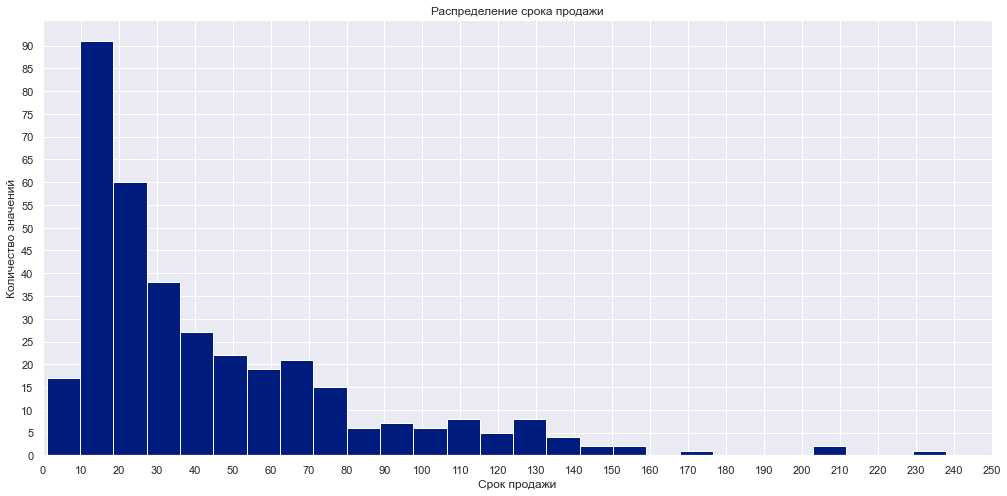

Средний срок продажи квартиры: 104.63275733394569
Медианное значение: 74.0


In [94]:
(
    df.query('days_exposition < 365').groupby(by='days_exposition').agg('flat_cat').count()
    .plot(
        kind='hist',bins=100,xlim=(0,250),grid=True,
          xticks=range(0,260,10),
          yticks=range(0,95,5)
         )
) #Построим финальную гистограмму
plt.ylabel('Количество значений')
plt.xlabel('Срок продажи')
plt.title('Распределение срока продажи')
plt.show()
print('Средний срок продажи квартиры:', df[df['days_exposition'] < 365]['days_exposition'].mean())
print('Медианное значение:', df[df['days_exposition'] < 365]['days_exposition'].median())

Необходимо удалить все значения маркером 9999, для дальнейшего анализа, так как продана эта квартира или нет, нам неизвестно и анализировать рынок на нереализованных объявлениях будет некорректно.

In [87]:

print('Доля значений для удаления:{:.2%}'.format(len(df.loc[df['days_exposition'] == 9999])/len(df)))
df = df.query('days_exposition < 9999')

Доля значений для удаления:0.00%


Значений с маркером более 10%, однако так как объявления не были сняты, мы не можем их использовать для оценки реальной рыночной ситуации.

##### Вывод 
Средний срок продажи квартиры `104` дня.
Проанализировав гистограмму мы можем сказать, что менее `10 дней` и более `140 дней`, можно считать пределами необычных значений при продаже квартиры.

### Задача: Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. 

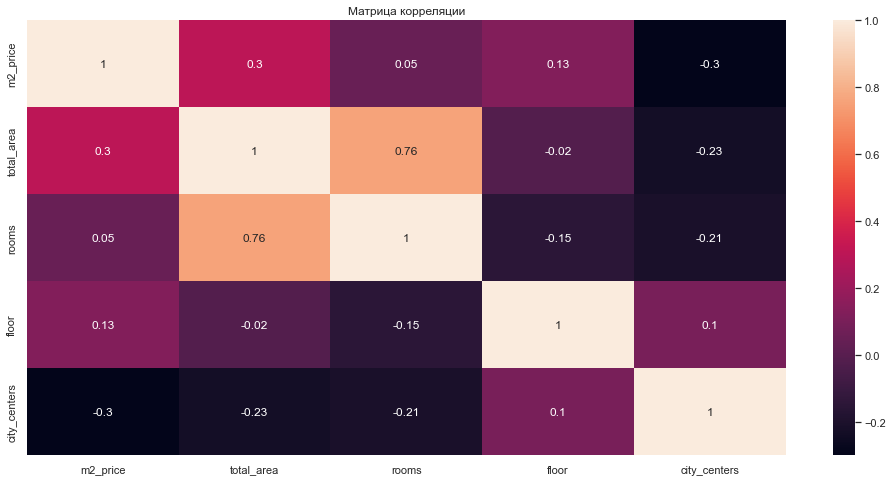

In [95]:
korr_data = df[['m2_price','total_area','rooms','floor']].copy() #Подготовим таблицу для анализа корреляции
korr_data['city_centers'] = df.loc[df['cityCenters_nearest'] > 0, 'cityCenters_nearest'] #Отфильтруем расстояние до центра с учетом маркера 
kd = korr_data.corr().round(2) #Построем матрицу корреляции и округлим значения
sns.heatmap(kd, annot=True) #Визуализируем матрицу

plt.title('Матрица корреляции')
plt.show()

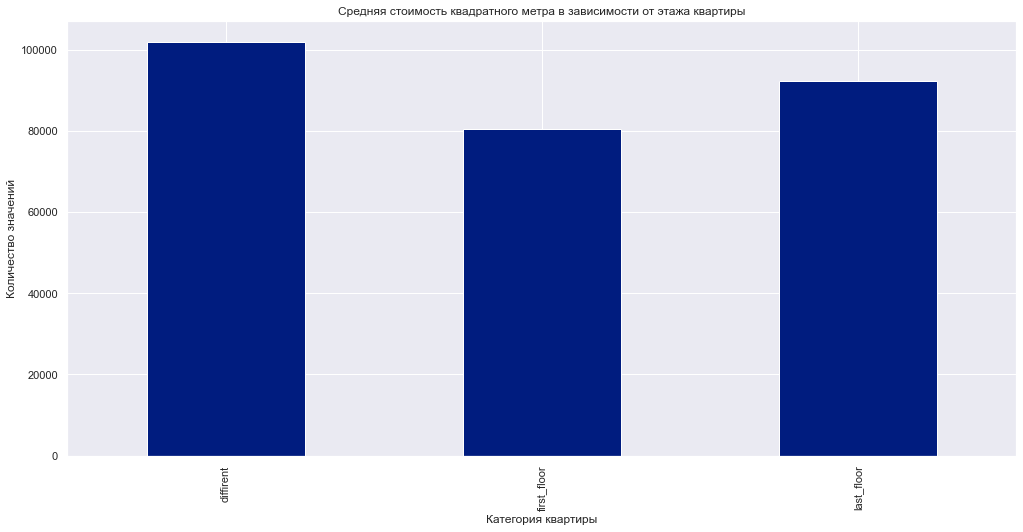

In [97]:
df.groupby(by='flat_cat').agg('m2_price').mean().plot.bar() #Построем гистограмму по категории этажности
plt.ylabel('Количество значений')
plt.xlabel('Категория квартиры')
plt.title('Средняя стоимость квадратного метра в зависимости от этажа квартиры')
plt.show()

Наименьшая стоимость квадратного метра у квартир на первом этаже

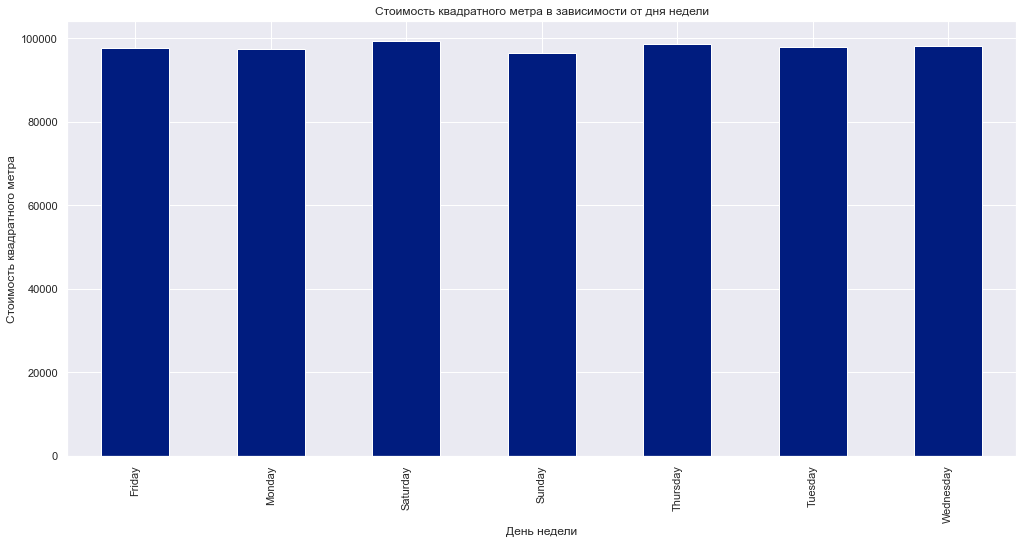

In [102]:
df.groupby(by='weekday_ad').agg('m2_price').mean().plot.bar() #Построем график по дням недели
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('День недели')
plt.title('Стоимость квадратного метра в зависимости от дня недели')
plt.show()

Стоимость квадратного метра не зависит от дня недели

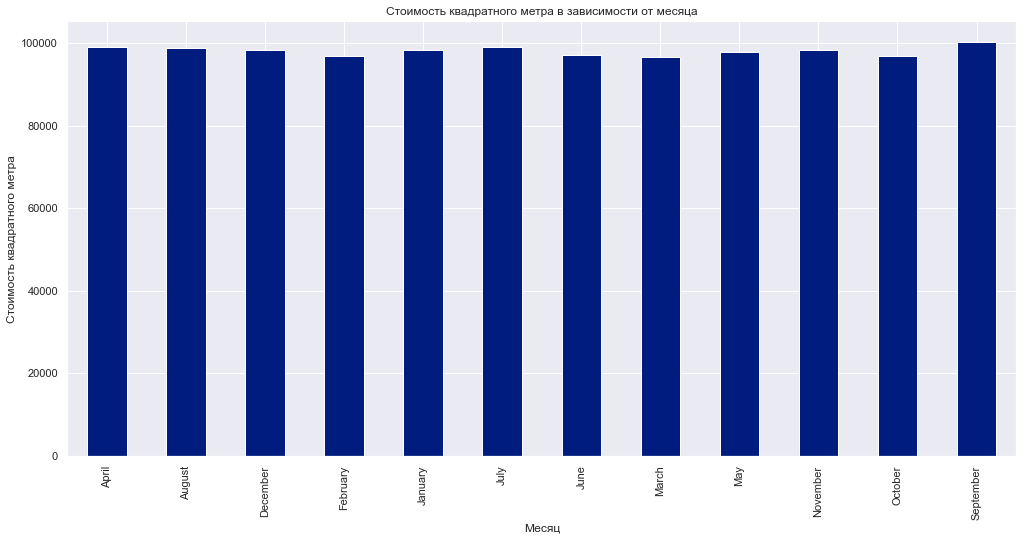

In [103]:
df.groupby(by='month_ad').agg('m2_price').mean().plot.bar() #Построем гистограмму 
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Месяц')
plt.title('Стоимость квадратного метра в зависимости от месяца')
plt.show()

Стоимость квадратного метра не зависит от месяца размещения объявления

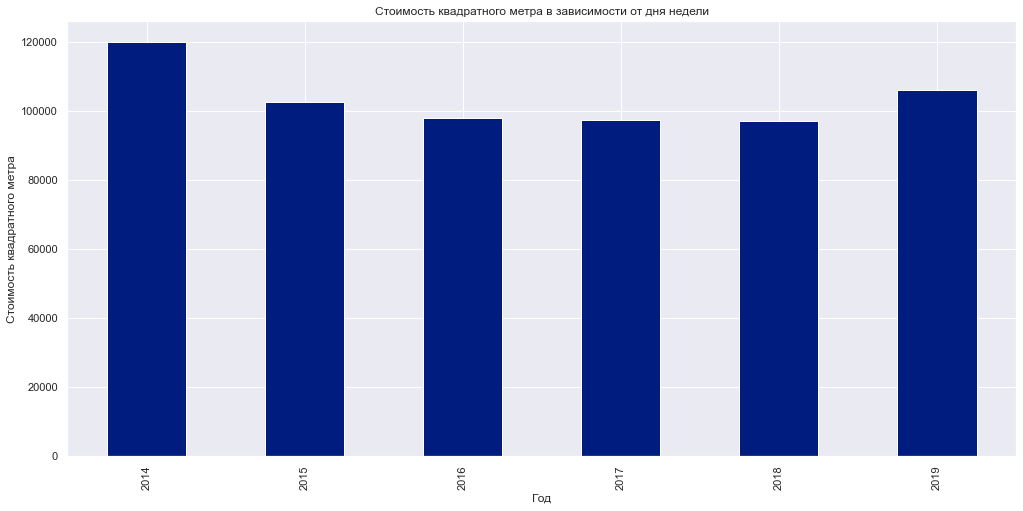

In [104]:
df.groupby(by='year_ad').agg('m2_price').mean().plot.bar() #Построем гистограмму по годам
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Год')
plt.title('Стоимость квадратного метра в зависимости от дня недели')
plt.show()

Самая большая цена за квадратный метр была в 2014 году

#### Вывод
Мы можем сделать следующие выводы:
1. Цена квадратного метра увеличивается с увеличением общей площади квартиры. Это связано с тем, что чем больше площадь тем элитней недвижимость считается.
2. Цена квадратного метра слабо зависит от числа комнат, это обусловлено и тем, что в большой квартире может быть мало комнат, а в маленькой, много комнат.
3. С увеличением этажа увеличивается и стоимость квадратного метра, однако на последнем этаже стоимость падает.
4. Цена квадратного метра увеличивается при приближении к центру.
5. Стоимость квадратного метра не зависит от дня размещения объявления
6. Стоимость квадратного метра не зависит от месяца размещения объявления
7. Наивысшая цена за квадратный метр была в 2014 году и только в 2019 начала снова расти.



### Задача: «Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`».

20470
locality_name
Санкт-Петербург        13638
поселок Мурино           551
посёлок Шушары           408
Всеволожск               339
Колпино                  308
                       ...  
поселок Гладкое            1
поселок Гончарово          1
поселок Дружноселье        1
поселок Жилпосёлок         1
село Шум                   1
Name: m2_price, Length: 288, dtype: int64


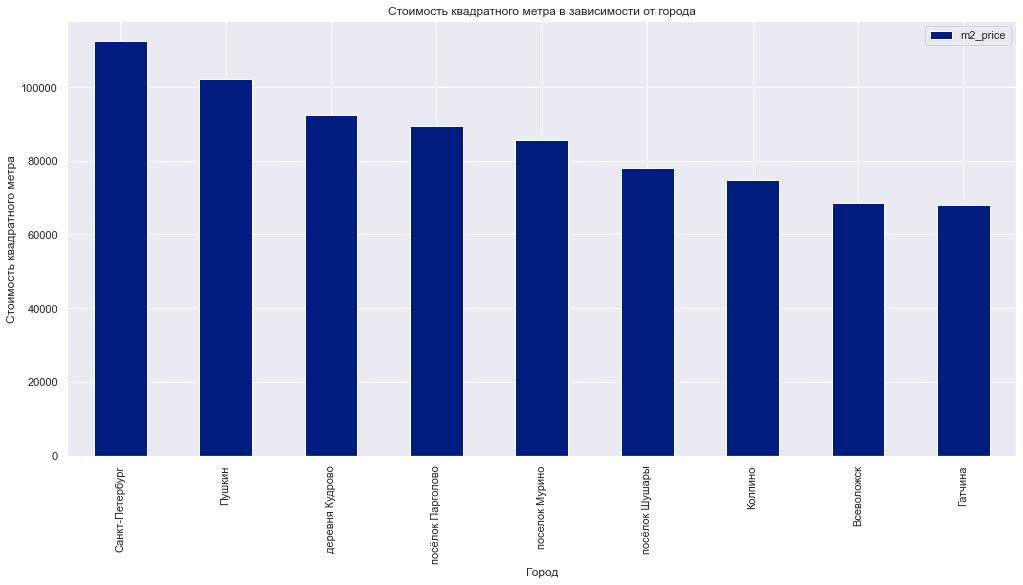

In [106]:
ten_city_mark = df.groupby(by='locality_name').agg('m2_price').count().sort_values(ascending=False)#Создадим сгруппированную таблицу по цене в населенных пунктах
print(ten_city_mark.sum())
print(ten_city_mark)
ten_city_mark = ten_city_mark[ten_city_mark > 236] #Отфильтруем для того, чтобы осталось 10 нужных населенных пунктов
ten_city = df.loc[df['locality_name'].isin(ten_city_mark.index),['locality_name','m2_price']] #Создадим таблицу где будут значения только по 10 крупнейшим городам
ten_city.pivot_table(index='locality_name', values='m2_price').sort_values(by='m2_price',ascending=False).plot.bar() #Создадим сводную таблицу по средней стоимости в крупных городах

plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Город')
plt.title('Стоимость квадратного метра в зависимости от города')
plt.show()

#### Вывод
Мы можем увидеть, что самая высокая стоимость квадратного метра в `Санкт-Петербурге`, а самая низкая в `Выборге`.

### Задача: «Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона».

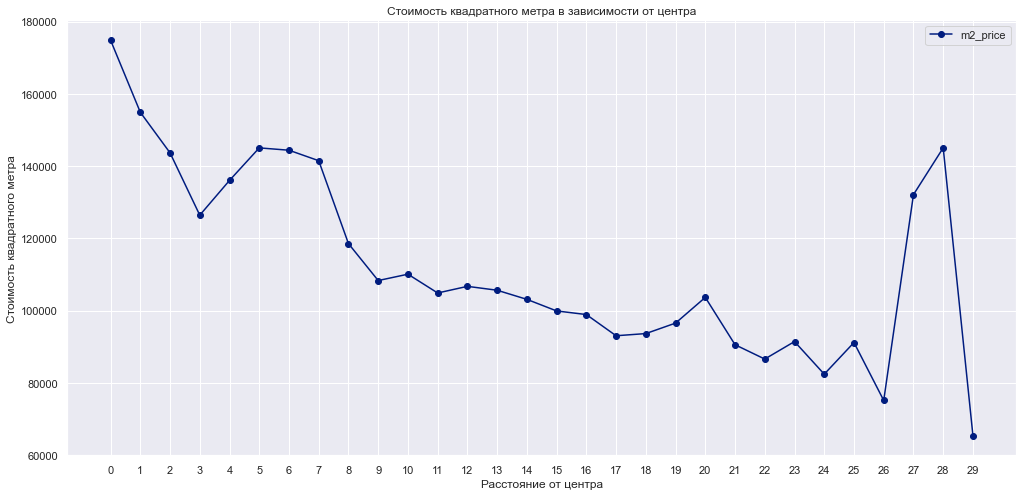

In [108]:
spb_flat = df.loc[df['locality_name'] == 'Санкт-Петербург',['m2_price','total_area','rooms','floor','ceiling_height','flat_cat','cityCenters_nearest','first_day_exposition','weekday_ad','month_ad','year_ad','days_exposition']] #Создадим отдельную таблицу с нужным нам данными по санкт-петербургу
spb_flat['cityCenters_nearest'] = (spb_flat['cityCenters_nearest'] / 1000).astype('int64') #Переведем расстояние до центра в километры и округлим через изменение типа
spb_flat.pivot_table(index='cityCenters_nearest', values='m2_price').plot(style='o-', grid=True,xticks=range(30)) #Построим график для оценки
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Расстояние от центра')
plt.title('Стоимость квадратного метра в зависимости от центра')
plt.show()

#### Вывод

Как мы видим, график резко увеличивается на отметке в `8 км`. С этого момента начинается центр.

### Задание: «Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?»

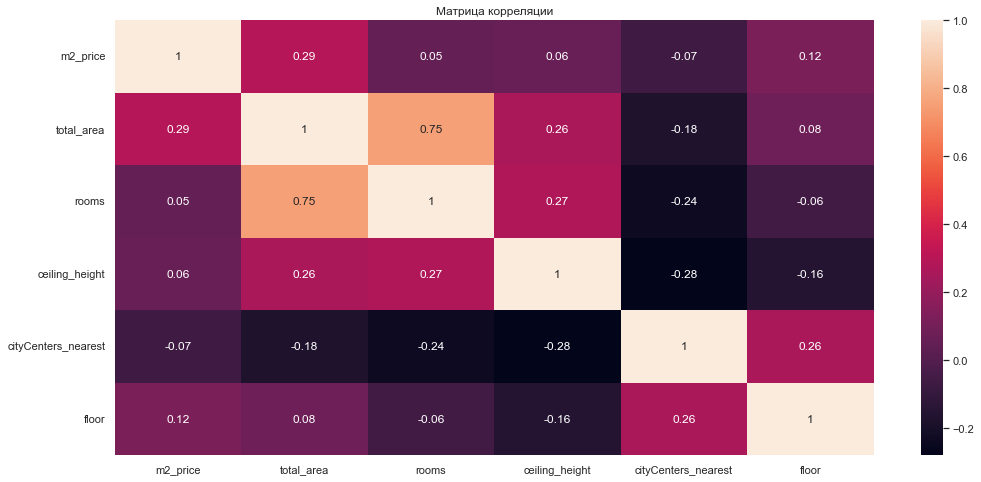

In [110]:
spb_flat_center = spb_flat.query('cityCenters_nearest <= 8') #Создадим срез данных по центру
spb_corr = spb_flat_center[['m2_price','total_area','rooms','ceiling_height','cityCenters_nearest','floor']].corr().round(2) #Создадим матрицу корреляции
sns.heatmap(spb_corr, annot=True) #Выведем матрицу в удобном виде

plt.title('Матрица корреляции')
plt.show()

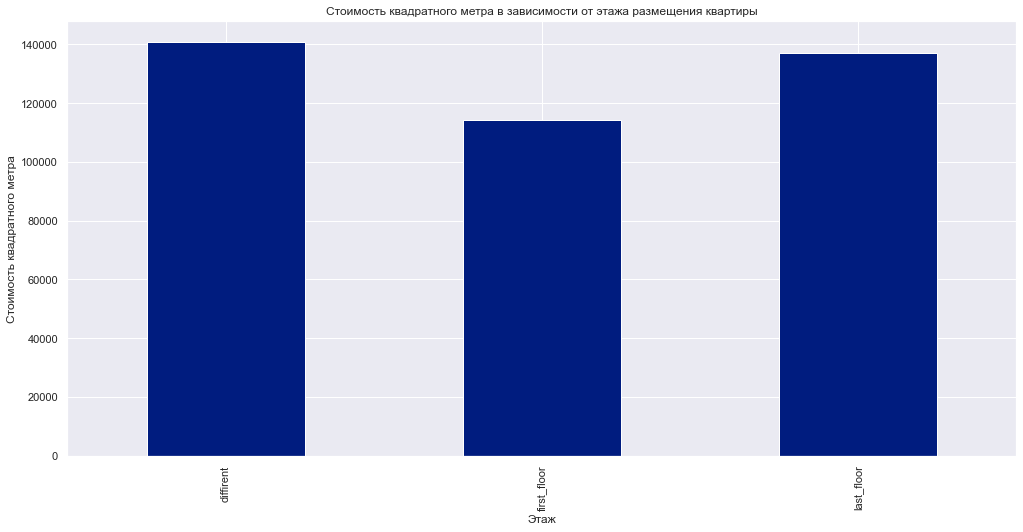

In [112]:
spb_flat_center.groupby(by='flat_cat').agg('m2_price').mean().plot.bar() #Построим столбчатый график по категории квартиры
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Этаж')
plt.title('Стоимость квадратного метра в зависимости от этажа размещения квартиры')
plt.show()

Стоимость квадратного метра меньше для первого этажа

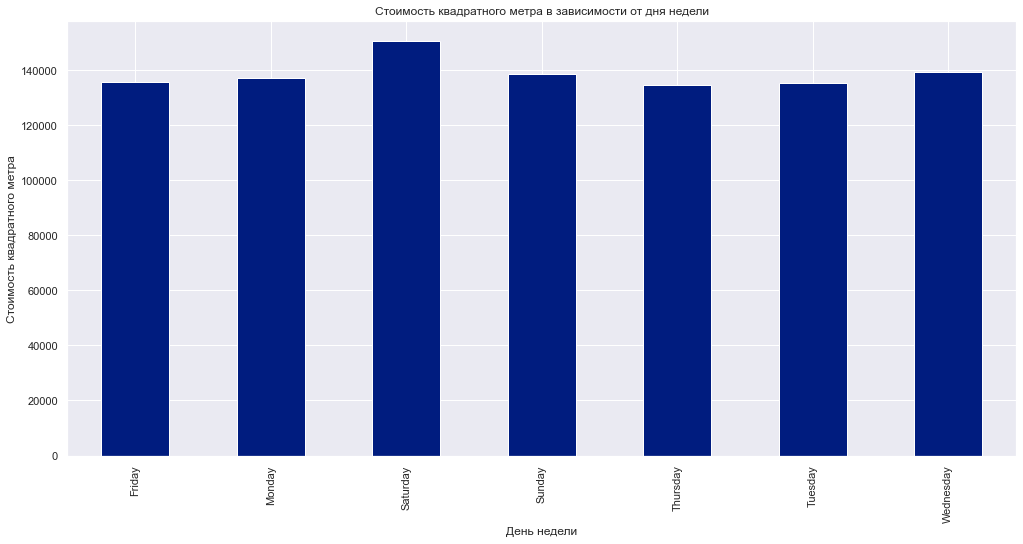

In [113]:
spb_flat_center.groupby(by='weekday_ad').agg('m2_price').mean().plot.bar() #Построим столбчатый график по дню недели
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('День недели')
plt.title('Стоимость квадратного метра в зависимости от дня недели')
plt.show()

Объявления размещенные в субботу стоят чуть дороже чем в другие дни недели

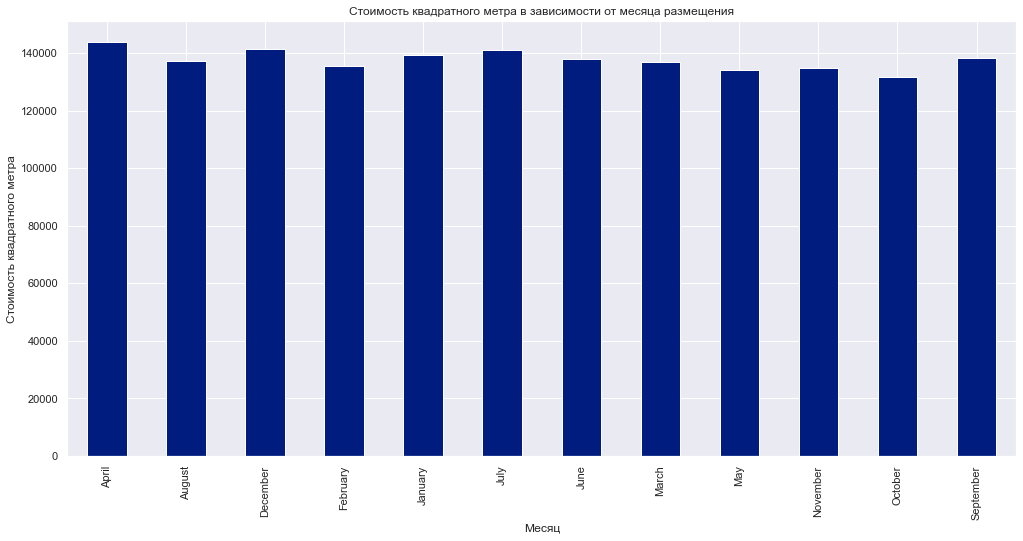

In [115]:
spb_flat_center.groupby(by='month_ad').agg('m2_price').mean().plot.bar() #Построим столбчатый график по месяцу
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Месяц')
plt.title('Стоимость квадратного метра в зависимости от месяца размещения')
plt.show()

Стоимость квадратного метра не зависит от месяца размещения

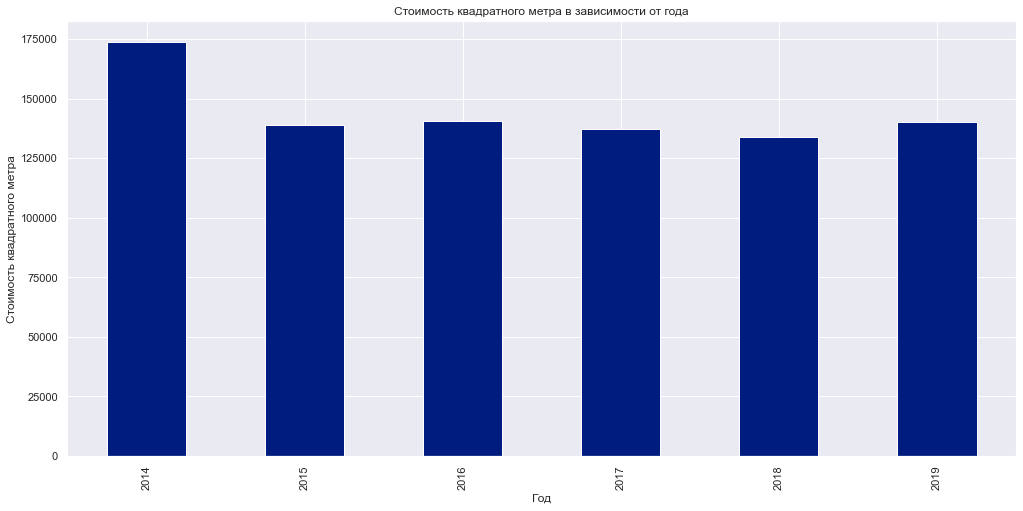

In [116]:
spb_flat_center.groupby(by='year_ad').agg('m2_price').mean().plot.bar() #Построим столбчатый график по году
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Год')
plt.title('Стоимость квадратного метра в зависимости от года')
plt.show()

#### Вывод
1. Цена квадратного метра увеличивается с увеличением общей площади квартиры. 
2. Цена квадратного метра не зависит от количества комнат
3. Цена квадратного метра слабо зависит от высоты потолков, так как в центре Санкт-Петербурга высота потолков примерно одинаковая.
4. Цена квадратного метра увеличивается с уменьшением расстояния до центра.
5. Цена квадратного метра увеличивается с увеличением этажа на котором находится квартира
6. Цена квадратного метра на первом этаже меньше чем на последующих
7. Цена квадратного метра для объявления размещенного в субботу чуть больше чем для других дней. Так как общее количество объявлений размещенных в выходные дни меньше, мы можем сказать, что скорее всего реальный собственник недвижимости оценивает свою квартиру в целом выше рынка.
8. Наивысшая цена за квадратный метр была в 2014 году и только в 2019 начала снова расти.

**Выводы по сравнению рынка недвижимости в центре Санкт-Петербурга и недвижимости в целом:**

1. У обычной недвижимости цена квадратного метра для квартиры на последнем этаже меньше чем на любых других кроме первого. А для элитной, стоимость квадратного метра ниже только для первого этажа. Скорее всего это связано с качеством ремонтаж крыш.
2. У обычной недвижимости нет зависимости от даты размещения объявления, а для элитной можно сделать вывод, что собственник размещающий объявление, склонен оценивать цену квадратного метра выше рынка.

## Общий вывод

**Рынок недвижимости в зависимости от даты выглядит следующим образом:**

1. С точки зрения дней продаж, мы можем увидеть, что частота размещения не зависит от дня, кроме выходных, скорее всего это связано с тем, что агенства недвижимости не размещают объявления в выходные дни.
2. Больше всего размещений в феврале,марте, апреле традиционно одними из самых насыщенных месяцев, а меньше всего в мае, что связано с длинным праздниками.
3. По годам больше всего размещений было в `2017` и `2018` годах, а в `2019` произошел резкий спад. Это связано с тем, что выгрузка заканчивается в начале мая `2019` из за чего большая часть объявлений не попала в выгрузку.
4. Средний срок продажи квартиры `104` дня.
5. Срок продажи менее `10 дней` и более `140 дней`, можно необычным при продаже квартиры.

**Анализ рынка недвижимости в общем:**

1. Цена квадратного метра увеличивается с увеличением общей площади квартиры. Это связано с тем, что чем больше площадь тем элитней недвижимость считается.
2. Цена квадратного метра слабо зависит от числа комнат, это обусловлено и тем, что в большой квартире может быть мало комнат, а в маленькой, много комнат.
3. С увеличением этажа увеличивается и стоимость квадратного метра, однако на последнем этаже стоимость падает.
4. Цена квадратного метра увеличивается при приближении к центру.
5. Стоимость квадратного метра не зависит от дня размещения объявления
6. Стоимость квадратного метра не зависит от месяца размещения объявления
7. Наивысшая цена за квадратный метр была в 2014 году и только в 2019 начала снова расти.

**Анализ рынка недвижимости в центральном районе Санкт-Петербурга (8 км от центра):**

1. Цена квадратного метра увеличивается с увеличением общей площади квартиры. 
2. Цена квадратного метра слабо зависит от количества комнат
3. Цена квадратного метра слабо зависит от высоты потолков, так как в центре Санкт-Петербурга высота потолков примерно одинаковая.
4. Цена квадратного метра увеличивается с уменьшением расстояния до центра.
5. Цена квадратного метра увеличивается с увеличением этажа на котором находится квартира
6. Цена квадратного метра на первом этаже меньше чем на последующих
7. Цена квадратного метра для объявления размещенного в субботу чуть больше чем для других дней. Так как общее количество объявлений размещенных в выходные дни меньше, мы можем сказать, что скорее всего реальный собственник недвижимости оценивает свою квартиру в целом выше рынка.
8. Наивысшая цена за квадратный метр была в 2014 году и только в 2019 начала снова расти.

**Выводы по сравнению рынка недвижимости в центре Санкт-Петербурга и рынка недвижимости в целом:**

1. У обычной недвижимости цена квадратного метра для квартиры на последнем этаже меньше чем на любых других кроме первого. А для элитной, стоимость квадратного метра ниже только для первого этажа. Скорее всего это связано с качеством ремонтаж крыш.
2. У обычной недвижимости нет зависимости от даты размещения объявления, а для элитной можно сделать вывод, что собственник размещающий объявление, склонен оценивать цену квадратного метра выше рынка.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: «Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?»
- [x]  выполнено задание: «Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили».
- [x]  выполнено задание: «Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года». 
- [x]  выполнено задание: «Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`».
- [x]  выполнено задание: «Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона».
- [x]  выполнено задание: «Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?»
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод